In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.preprocessing_numpy import *
from HN_decomposition.Subspace.ESPRIT_numpy import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

### Creating a basic modulated sine-wave

In [3]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .1

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
#x = sineAmp*np.sin(full_phase)
#x += noiseAmp*np.random.randn(np.shape(t)[0])


## Loading the audio file

In [4]:
fileName = os.path.join('..', 'Data', 'Test', '69.wav')
x, sr_hz = librosa.load(fileName)
x = x[:2*sr_hz]



In [5]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "preprocessing", "Figures")

## Sub-band decomposition

(44100,)


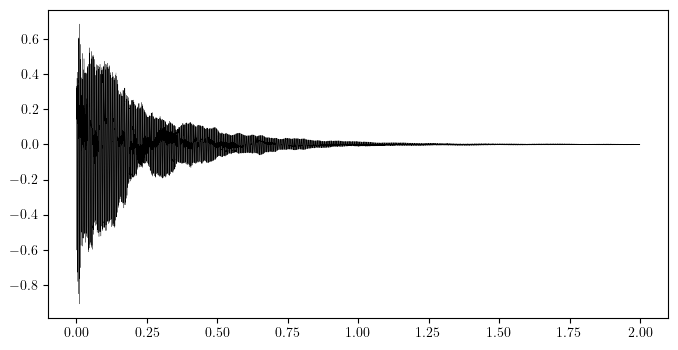

In [6]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [(numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal



print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

## Whitening the noise

In [7]:
sr_hz = 22050
t = np.arange(2*sr_hz)
baseFreq = 440*4/sr_hz #Hz
modFreq = 1/sr_hz #Hz
modAmp = 100/sr_hz #Hz
sineAmp = 1
noiseAmp = .01

full_phase = baseFreq*t + modAmp/(2*np.pi*modFreq)*np.cos(2*np.pi*modFreq*t)
full_phase *= 2*np.pi
x = sineAmp*np.sin(full_phase)
x += noiseAmp*np.random.randn(np.shape(t)[0])


In [8]:
rankFilter_bins = 21
rankFilter_rank = .3

n_fft = 512
hop_length = n_fft

In [9]:

print(np.shape(x))
x_stft = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length, center=False)

xRankFiltered_stft = rankFilter_stft(x_stft, rankFilter_bins = rankFilter_bins, rankFilter_rank = rankFilter_rank)

window_type = 'hann'
xWhitened, xChopped, ARFilters = window_and_whiten_signal(
    x = x,
    window_length = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)
xWhitened_stft = compute_stft_from_windowed(xWhitened, window_type=window_type)

t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

time_frame_display = 11


(44100,)
sample rate : 22050


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


## Base ESPRIT

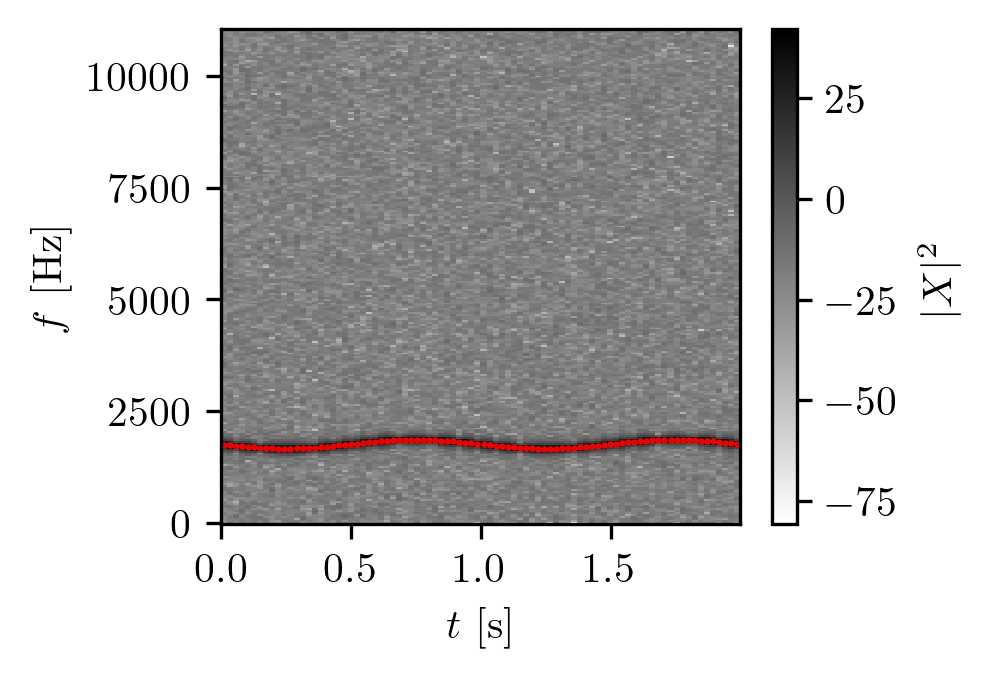

In [10]:
num_poles = 2

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)

xHarmoChopped = np.zeros(np.shape(xChopped))
xHarmo = np.zeros(np.shape(x))

for timeFrame in range(np.shape(xWhitened)[0]):
    poles, complexAmp, Lambda = ESPRIT(xWhitened[timeFrame], num_poles = num_poles)
    freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]
    plt.plot(np.ones(num_poles//2)*t_list[timeFrame], freqs, 'r.', markersize = 1)
    for i, pole in enumerate(poles):
        xHarmoChopped[timeFrame] += np.real(np.power(pole*np.ones(np.shape(xHarmoChopped)[1]), np.arange(np.shape(xHarmoChopped)[1]))*complexAmp[i])
    xHarmoChopped[timeFrame] = sig.lfilter([1], ARFilters[timeFrame], xHarmoChopped[timeFrame])
    xHarmo[hop_length*timeFrame:hop_length*timeFrame+n_fft] += xHarmoChopped[timeFrame]
    
display(Audio(x, rate = sr_hz))
display(Audio(xHarmo, rate = sr_hz))
display(Audio(x-xHarmo, rate = sr_hz))

scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'input.wav'), rate =sr_hz, data = normalize(x))
scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'harmo.wav'), rate =sr_hz, data = normalize(xHarmo))
scipy.io.wavfile.write(os.path.join('HN/Subspace/Audio', 'noise.wav'), rate =sr_hz, data = normalize(x-xHarmo))

plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
#plt.savefig(fname = os.path.join(save_folder, "ESPRIT_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()




## Adaptative ESPRIT

In [51]:
sr_hz = 22050
length_sec = 1.

def mod_sine(length_sec, baseFreq, modFreq, modAmp, sr_hz=1):
    t = np.arange(int(length_sec*sr_hz))
    full_phase = baseFreq/sr_hz*t + modAmp/sr_hz/(2*np.pi*modFreq/sr_hz)*np.cos(2*np.pi*modFreq/sr_hz*t)
    full_phase *= 2*np.pi
    return np.sin(full_phase)

x = np.zeros(int(length_sec*sr_hz), dtype = 'float64')
x += 1*mod_sine(length_sec=length_sec, baseFreq = 440, modFreq = 1, modAmp = 100, sr_hz=sr_hz)
x += .5*mod_sine(length_sec=length_sec, baseFreq = 5500, modFreq = .6, modAmp = 2000, sr_hz=sr_hz)
x += .5*mod_sine(length_sec=length_sec, baseFreq = 6600, modFreq = .6, modAmp = 2000, sr_hz=sr_hz)

x += .1*np.random.randn(int(length_sec*sr_hz))

fileName = os.path.join('..', 'Data', 'Test', '76.wav')
x, sr_hz = librosa.load(fileName)
x = x[int(.1*sr_hz):int((length_sec+.1)*sr_hz)]



c:\Users\pelad\Documents\Scolarite\sorbonne_universite\2022_2023\Cours\Projet d'Application Musicale\Projet\ATIAM-PAM-AnalyseInstruments\Notebooks\..\HN_decomposition\Subspace\ESPRIT_numpy.py:167: RuntimeWarning: overflow encountered in matmul
  eps_bf = (tau/eta)*(Z@g - (hprim.H@g)[0,0]*g)
c:\Users\pelad\Documents\Scolarite\sorbonne_universite\2022_2023\Cours\Projet d'Application Musicale\Projet\ATIAM-PAM-AnalyseInstruments\Notebooks\..\HN_decomposition\Subspace\ESPRIT_numpy.py:167: RuntimeWarning: invalid value encountered in matmul
  eps_bf = (tau/eta)*(Z@g - (hprim.H@g)[0,0]*g)
c:\Users\pelad\Documents\Scolarite\sorbonne_universite\2022_2023\Cours\Projet d'Application Musicale\Projet\ATIAM-PAM-AnalyseInstruments\Notebooks\..\HN_decomposition\Subspace\ESPRIT_numpy.py:167: RuntimeWarning: overflow encountered in multiply
  eps_bf = (tau/eta)*(Z@g - (hprim.H@g)[0,0]*g)
c:\Users\pelad\Documents\Scolarite\sorbonne_universite\2022_2023\Cours\Projet d'Application Musicale\Projet\ATIAM-PAM

Temps d'execution : 7.457154273986816


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


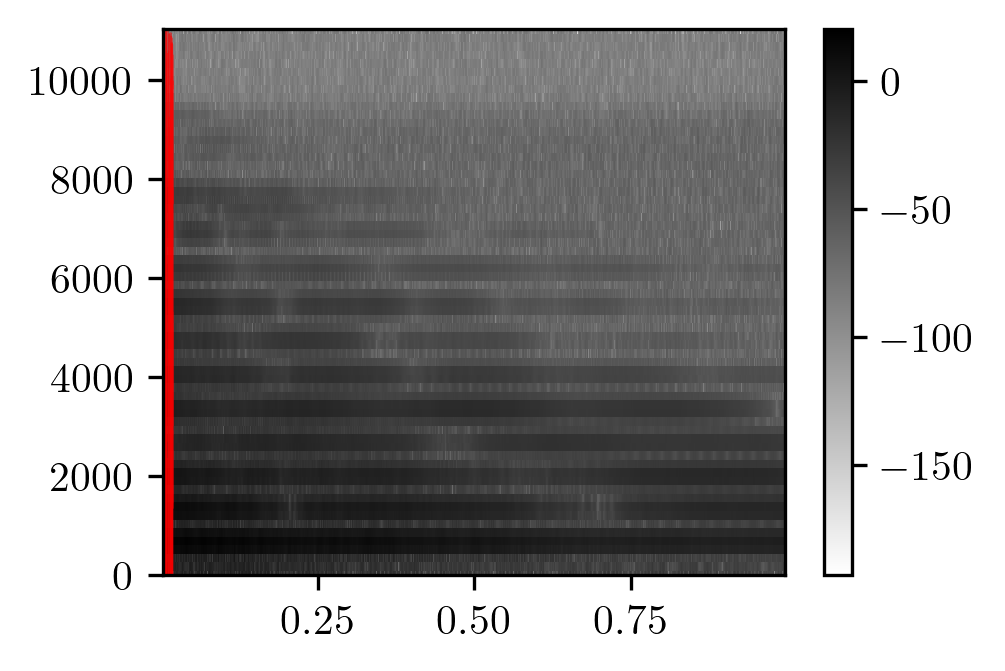

In [52]:
rankFilter_bins = 12
rankFilter_rank = .3

n_fft = 128
hop_length = 1

num_poles = 4

x_stft = librosa.stft(x, n_fft = n_fft, hop_length = hop_length, center=False)


xWhitened, xChopped, ARFilters = window_and_whiten_signal(
    x = sig.hilbert(x),
    window_length = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)

tic = time.time()
poles_list = HRHATRAC(
    xWhitened,
    num_poles = num_poles,
    beta = .9,
    mu_L = .1,
    mu_V = .1)

toc = time.time()
print(f"Temps d'execution : {toc-tic}")
xWhitened_stft = compute_stft_from_windowed(xWhitened, window_type=window_type)
t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

freqs_list = sr_hz*np.angle(poles_list)/(2*np.pi)
plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)
for pole_idx in range(num_poles):
    plt.plot(t_list,freqs_list[:,pole_idx], 'r-', alpha = .5)
plt.ylim(0, 11025)
plt.colorbar()
plt.show()


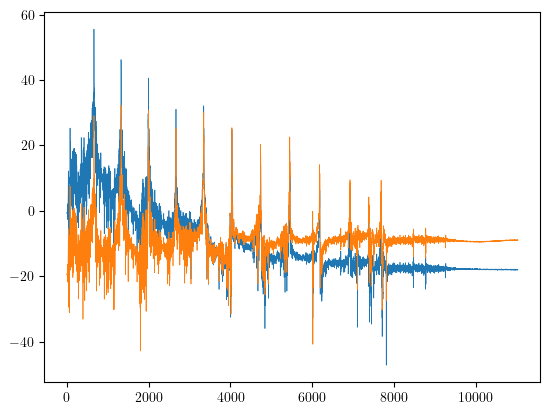

Temps d'execution : 10.944074630737305


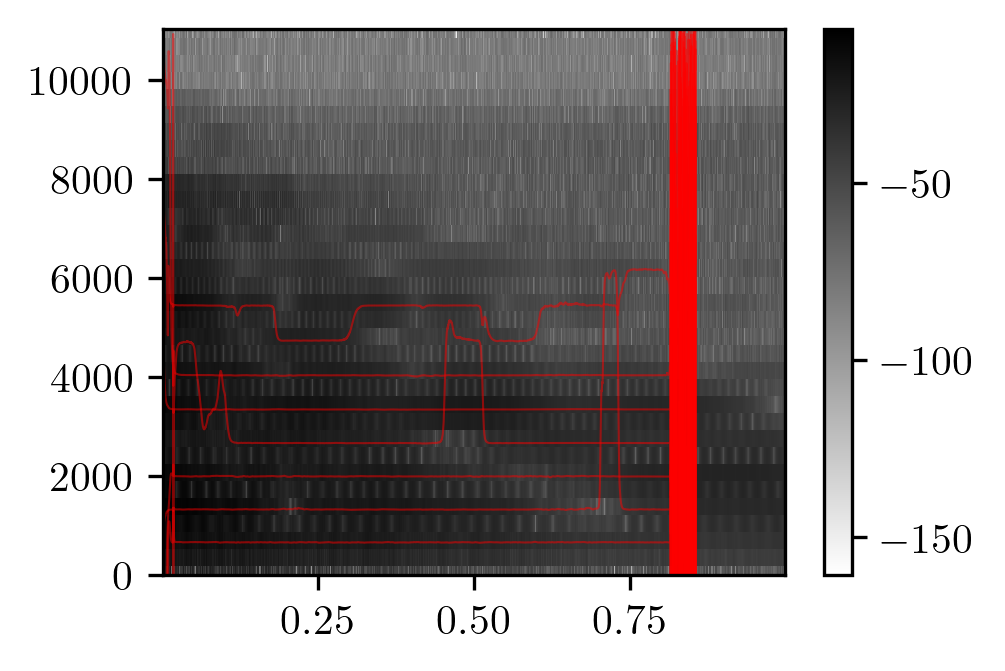

In [72]:
n_fft = 64
hop_length = 1

num_poles = 7


xWhitened, ARFilter = whiten_signal(
    sig.hilbert(x),
    rankFilter_bins = len(x)//100,
    rankFilter_rank = .3,
    ARFilter_length = 12,
    window_type="boxcar"
)

plt.plot(dB20(np.fft.rfft(x)))
plt.plot(dB20(np.fft.rfft(xWhitened)))
plt.show()

xWhitenedWindowed = window_signal(
    xWhitened,
    window_length = n_fft,
    hop_length = hop_length,
    window_type = "boxcar"
)


tic = time.time()
poles_list = HRHATRAC(
    xWhitenedWindowed,
    num_poles = num_poles,
    beta = .99,
    mu_L = .1,
    mu_V = .1)

toc = time.time()
print(f"Temps d'execution : {toc-tic}")
xWhitened_stft = compute_stft_from_windowed(
    xWhitenedWindowed,
    window_type=window_type
)

t_list = librosa.frames_to_samples(np.arange(np.shape(xWhitened_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

freqs_list = sr_hz*np.angle(poles_list)/(2*np.pi)
plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, rasterized=True)
for pole_idx in range(num_poles):
    plt.plot(t_list,freqs_list[:,pole_idx], 'r-', alpha = .5)
plt.ylim(0, 11025)
plt.colorbar()
plt.show()